In [8]:
import numpy as np

from matplotlib import pyplot as plt

from snn.graphs import plot_network
from snn.resonator import create_excitatory_resonator, create_excitatory_inhibitory_resonator, test_resonator_on_chirp


In [2]:
from utils import copy_filter_hp_to_other_clock_frequency

# copy_filter_hp_to_other_clock_frequency(1536000, 15360)

In [3]:
def resonator_output_spikes_on_chirp(
        freq0,
        clk_freq,
        save_figure=False,
        neurons_log_potentials=None,
        neurons_log_spikes=None
):
    my_resonator = create_excitatory_inhibitory_resonator(freq0=freq0, clk_freq=clk_freq)
    neurons_log_potentials = neurons_log_potentials or []
    for i in neurons_log_potentials:
        my_resonator.log_membrane_potential(i)

    neurons_log_spikes = neurons_log_spikes or []
    for i in neurons_log_spikes:
        my_resonator.log_out_spikes(i)

    start_freq = 0
    spectrum = 2 * float(freq0)
    test_size = int(spectrum * clk_freq)
    spikes_neuron = my_resonator.neurons[-1]

    spikes_neuron.membrane_sample_max_window = np.zeros(1).astype('float32')
    test_resonator_on_chirp(
        my_resonator,
        start_freq=start_freq,
        step=1/clk_freq,
        test_size=test_size,
        clk_freq=clk_freq
    )

    for i in neurons_log_potentials:
        spikes_neuron = my_resonator.neurons[i]
        membrane_neuron = my_resonator.neurons[i]
        y_membrane = membrane_neuron.membrane_potential_graph()
        x = np.linspace(start_freq, start_freq + spectrum, len(y_membrane))
        plt.title(f'membrane potential f={freq0}, neuron={i}')
        plt.plot(x, y_membrane)
        plt.show()

    for i in neurons_log_spikes:
        spikes_neuron = my_resonator.neurons[i]
        y_events = spikes_neuron.out_spikes()
        y_spikes = np.zeros(y_events[-1] + 1)
        y_spikes[y_events] = 1
        spikes_window_size = clk_freq//10
        y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
        x = np.linspace(start_freq, start_freq + spectrum, len(y_spikes))
        plt.title(f'spikes in window of {spikes_window_size} freq: {freq0}')
        if save_figure:
            plt.savefig('plot.png', dpi=300, bbox_inches='tight')
            plt.close()
        else:
            plt.plot(x, y_spikes)
            plt.show()

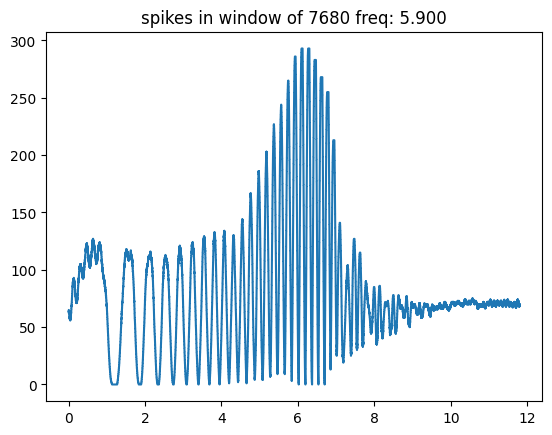

In [25]:
resonator_output_spikes_on_chirp(freq0='5.900', clk_freq=76800, neurons_log_spikes=[-1])

In [32]:
def plot_resonator_on_freq(signal_freq, clk_freq, resonator_freq, duration=2, show=True, weights=None, neurons_log_spikes=None):
    my_resonator = create_excitatory_inhibitory_resonator(freq0=resonator_freq, clk_freq=clk_freq)
    steps = clk_freq

    neurons_log_spikes = neurons_log_spikes or []
    for i in neurons_log_spikes:
        my_resonator.log_out_spikes(i)

    spectrum = duration * float(resonator_freq)
    if type(signal_freq) is not list:
        signal_freq = [signal_freq]

    weights = weights or np.ones(len(signal_freq))

    x = np.linspace(0, spectrum, int(spectrum * steps))
    t = x * 2 * np.pi * signal_freq[0]
    sine_wave = np.sin(t) * weights[0]
    for w, f in zip(weights[1:], signal_freq[1:]):
        t = x * 2 * np.pi * f
        sine_wave += np.sin(t) * w

    sine_wave /= np.max(sine_wave)

    my_resonator.input_full_data(np.zeros(steps * 5))
    for i in neurons_log_spikes:
        output_neuron = my_resonator.neurons[i]
        output_neuron.forget_logs()
    my_resonator.input_full_data(sine_wave)
    spikes_window_size = steps // 10

    for i in neurons_log_spikes:
        output_neuron = my_resonator.neurons[i]
        y_events = output_neuron.out_spikes()
        y_spikes = np.zeros(y_events[-1] + 1)
        y_spikes[y_events] = 1
        y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
        plt.title(f'signal freq {signal_freq}')
        plt.plot(np.linspace(0, duration, len(y_spikes)), y_spikes, label=signal_freq)

    if show:
        plt.show()

    return my_resonator

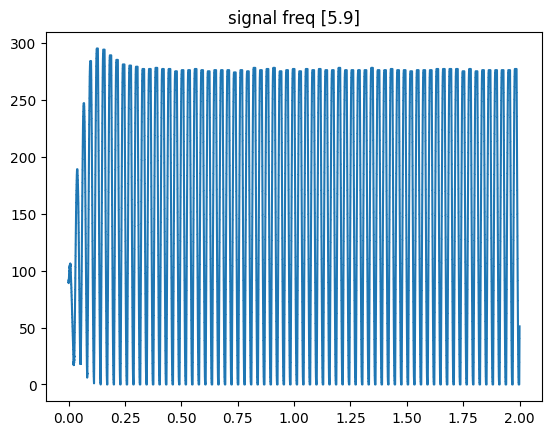

In [35]:
plot_resonator_on_freq(5.9, clk_freq=76800, resonator_freq='5.900')

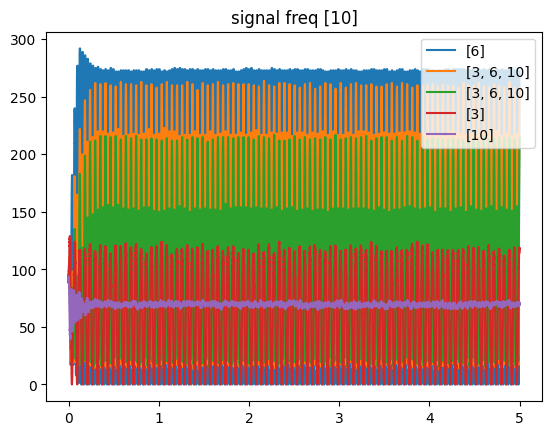

In [37]:
clk_freq = 76800
duration = 5
resonator_freq = '5.900'
plot_resonator_on_freq(6, clk_freq=clk_freq, resonator_freq=resonator_freq, duration=duration, show=False)
plot_resonator_on_freq([3, 6, 10], weights=[1, 2, 1], clk_freq=clk_freq, resonator_freq=resonator_freq, duration=duration, show=False)
plot_resonator_on_freq([3, 6, 10], weights=[1, 1, 1], clk_freq=clk_freq, resonator_freq=resonator_freq, duration=duration, show=False)
plot_resonator_on_freq(3, clk_freq=clk_freq, resonator_freq=resonator_freq, duration=duration, show=False)
plot_resonator_on_freq(10, clk_freq=clk_freq, resonator_freq=resonator_freq, duration=duration, show=False)
plt.legend(loc="upper right")
plt.show()

## Depict Phase Shifting

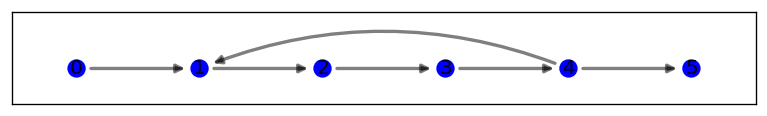

In [226]:
from snn.graphs import plot_network
from snn.resonator import create_excitatory_inhibitory_resonator, create_excitatory_resonator

my_resonator = create_excitatory_resonator(freq0='5.900', clk_freq=76800)
plot_network(my_resonator)

In [551]:
clk_freq = 76800
duration = 5
resonator_freq = '5.900'
my_resonator = create_excitatory_resonator(freq0=resonator_freq, clk_freq=clk_freq)
signal_freq = 6

neurons_log_spikes = range(6)
for i in neurons_log_spikes:
    my_resonator.log_out_spikes(i)

spectrum = duration

x = np.linspace(0, spectrum, int(duration * clk_freq))
t = x * 2 * np.pi * signal_freq
sine_wave = np.sin(t)

my_resonator.input_full_data(np.zeros(clk_freq * 5))
for i in neurons_log_spikes:
    output_neuron = my_resonator.neurons[i]
    output_neuron.forget_logs()
my_resonator.input_full_data(sine_wave)
None

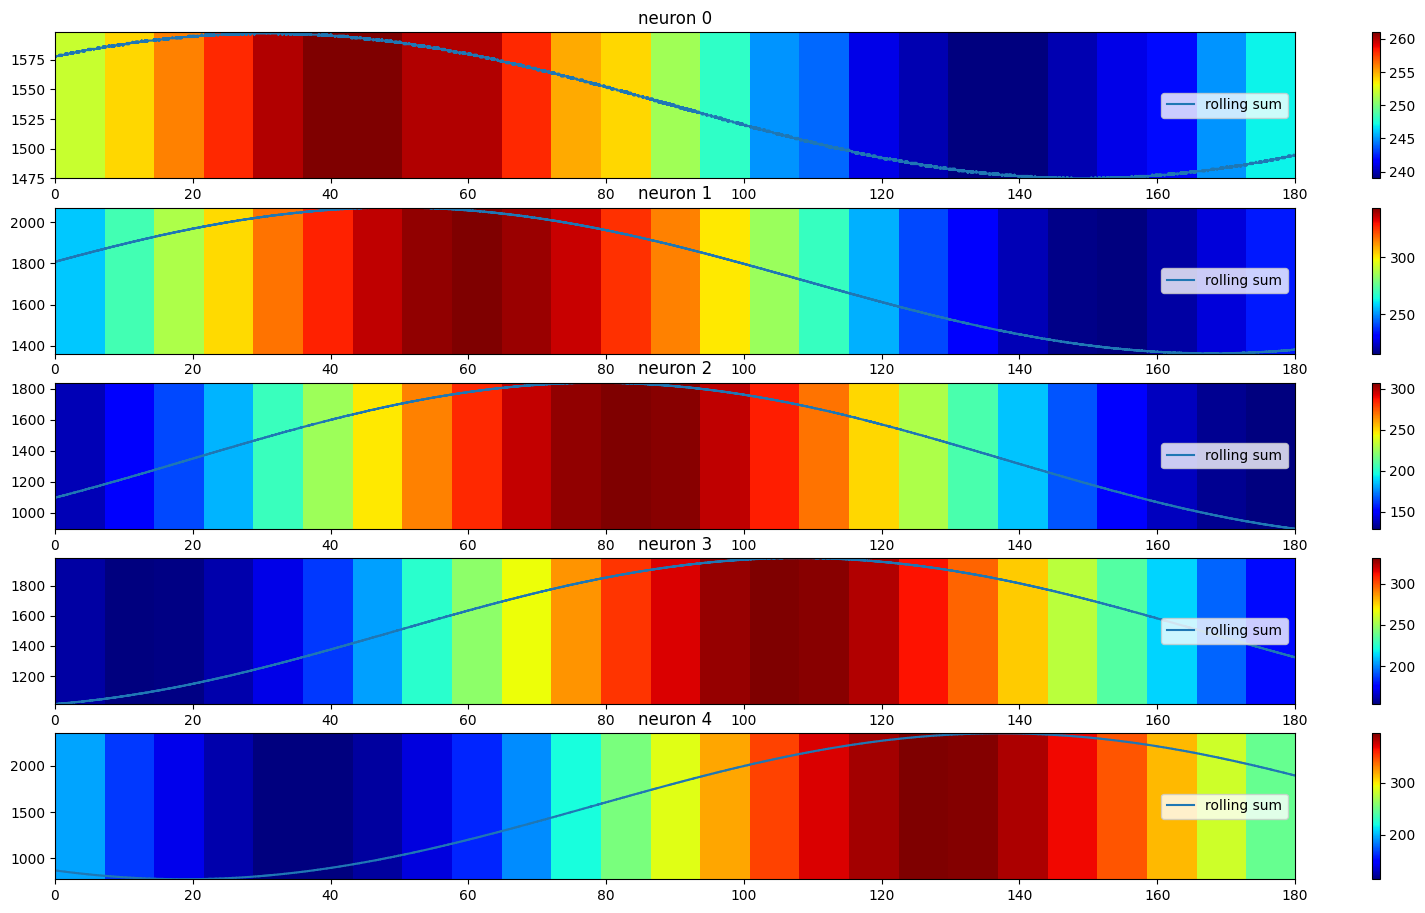

In [578]:
spikes_window_size = clk_freq // 50
fig, axs = plt.subplots(5, 1, figsize=(20, 11))

for i in neurons_log_spikes[:-1]:
    if i == 0:
        spikes_window_size *= 2
    output_neuron = my_resonator.neurons[i]
    y_events = output_neuron.out_spikes()
    y_events = y_events[(y_events > (duration - (3/signal_freq)) * clk_freq) & (y_events < (duration - (2/signal_freq)) * clk_freq)]
    y_events -= y_events[0]
    y_spikes = np.zeros(y_events[-1] + 1)
    y_spikes[y_events] = 1
    y_spikes_rollsum = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
    max_spikes = np.max(y_spikes_rollsum)
    min_spikes = np.min(y_spikes_rollsum)

    bin_window = 500
    pdm = y_spikes[:-(len(y_spikes)%bin_window)]
    pdm = pdm.reshape(-1, bin_window).sum(axis=1)
    pdm = np.array([pdm])
    ax = axs[i]
    ax.set_title(f'neuron {i}')
    im = ax.imshow(pdm, aspect='auto',
               cmap='jet', origin='lower',
               extent=[0, 180, min_spikes, max_spikes],
               )
    fig.colorbar(im, ax=ax)
    ax.plot(np.linspace(0, 180, len(y_spikes_rollsum)), y_spikes_rollsum, label=f'rolling sum')

    ax.legend(loc='right')

plt.show()

## Depict Resonator

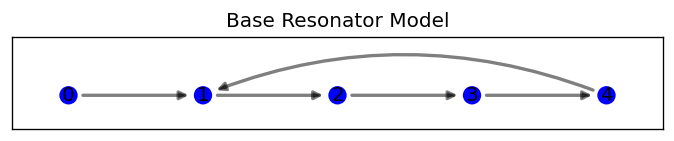

In [12]:
from snn.resonator import create_chirp_signal, create_base_resonator
from numba import njit


@njit
def test_frequency(network, test_size=10_000_000, start_freq=0, step=1 / 200000, clk_freq=1536000):
    batch_size = 50_000
    shift = 0
    while test_size > 0:
        sine_size = min(batch_size, test_size)
        sine_wave, freqs = create_chirp_signal(sine_size, clk_freq, start_freq, step, shift)

        network.input_full_data(sine_wave)

        shift = freqs[-1]
        start_freq += sine_size * step
        test_size -= sine_size

def custom_resonator_output_spikes(
        resonator,
        freq0,
        clk_freq,
        sample_rate=1,
        step = None,
        save_figure=False,
        path=None,
        plot=True
):
    resonator.log_out_spikes(-1)
    start_freq = 0
    spectrum = 2 * freq0
    step = step or 1 / clk_freq / sample_rate
    test_size = int(spectrum / step)
    spikes_neuron = resonator.neurons[-1]

    spikes_neuron.membrane_sample_max_window = np.zeros(1).astype('float32')
    test_frequency(
        resonator,
        start_freq=start_freq,
        step=step,
        test_size=test_size,
        clk_freq=clk_freq
   )

    events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(events[-1] + 1)
    y_spikes[events] = 1

    if path is not None:
        np.savez_compressed(path, spikes=y_spikes)

    spikes_window_size = 1000
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq + spectrum, len(y_spikes))
    plt.title(f'spikes in window of {spikes_window_size} freq: {freq0}')
    plt.plot(x, y_spikes)
    if save_figure:
        plt.savefig(f'../filters/clk_{clk_freq}/figures/f_{freq0:.3f}.PNG', bbox_inches='tight')
        plt.close()
    elif plot:
        plt.show()


freq0 = 5.9
clk_freq = 76800
resonator = create_base_resonator(freq0=f'{freq0:.3f}', clk_freq=clk_freq)
plot_network(resonator)
plt.title('Base Resonator Model')
None

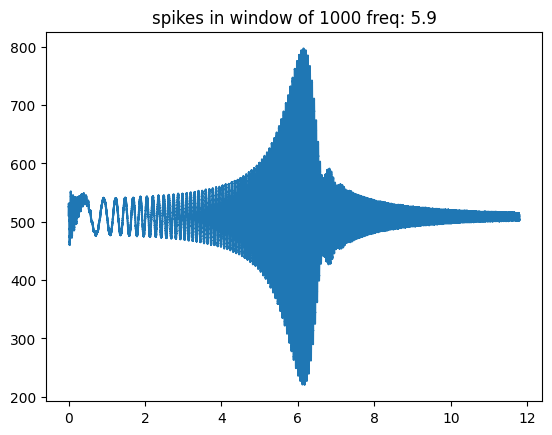

In [586]:
custom_resonator_output_spikes(resonator, freq0, clk_freq, sample_rate=3)

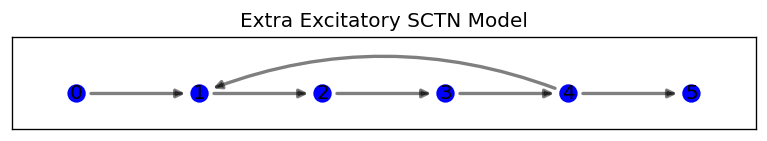

In [9]:
resonator = create_excitatory_resonator(freq0=f'{freq0:.3f}', clk_freq=clk_freq)
plot_network(resonator)
plt.title('Extra Excitatory SCTN Model')
None

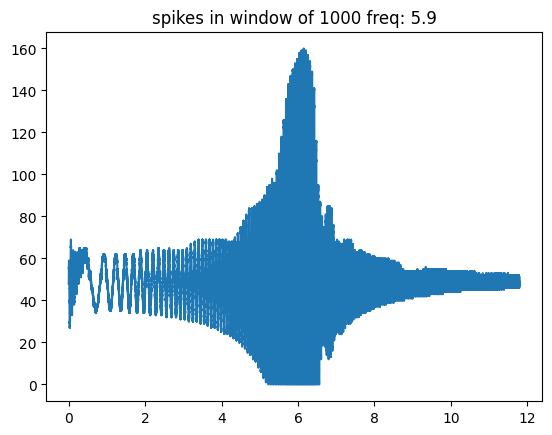

In [585]:
custom_resonator_output_spikes(resonator, freq0, clk_freq, sample_rate=3)

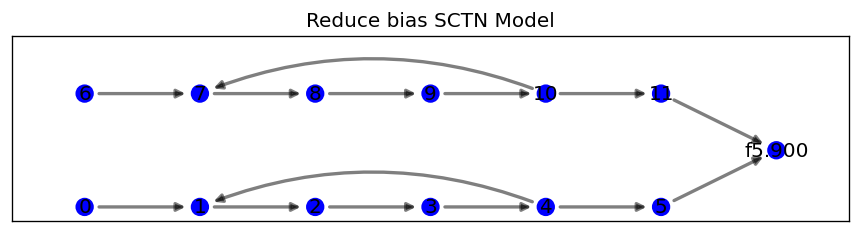

In [10]:
resonator = create_excitatory_inhibitory_resonator(freq0=f'{freq0:.3f}', clk_freq=clk_freq)
plot_network(resonator)
plt.title('Reduce bias SCTN Model')
None

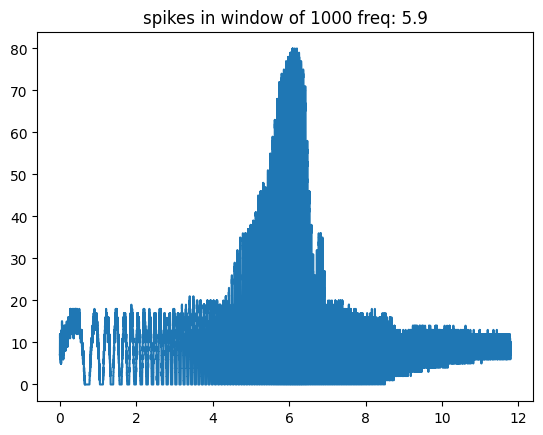

In [587]:
custom_resonator_output_spikes(resonator, freq0, clk_freq, sample_rate=3)

### Check Resonator 104 Amplitudes!

Text(0.5, 1.0, 'Base Resonator Model')

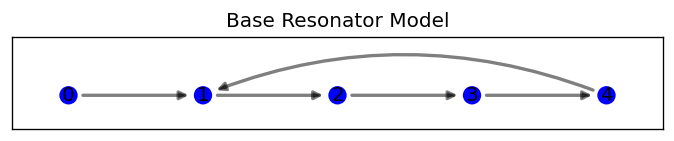

In [14]:
freq0 = 104
clk_freq = 1536000
resonator = create_base_resonator(freq0=f'{freq0}', clk_freq=clk_freq)
plot_network(resonator)
plt.title('Base Resonator Model')

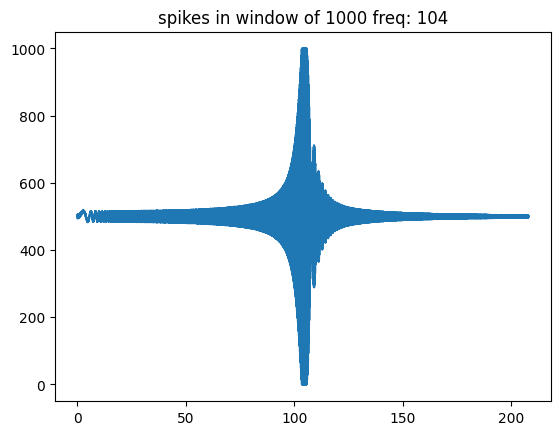

In [19]:
resonator.neurons[-1].forget_logs()
custom_resonator_output_spikes(resonator, freq0, clk_freq, sample_rate=1, step=1/100000)

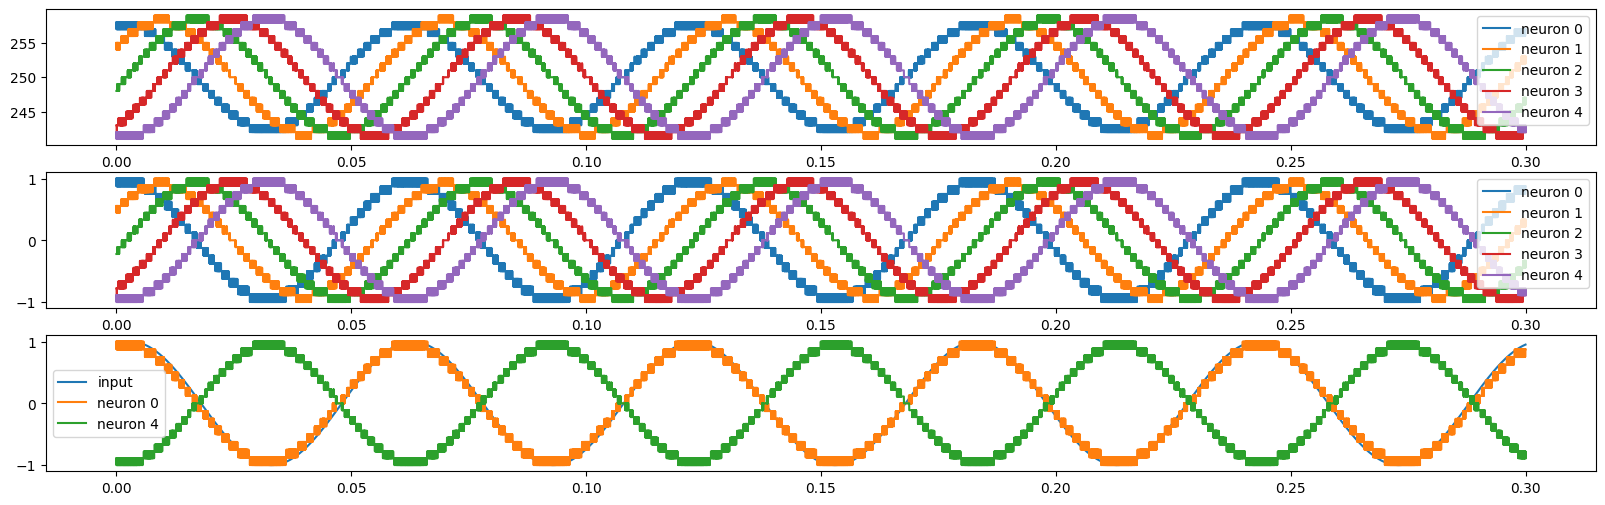

In [126]:
duration = .3

resonator_freq = '104'
clk_freq = 1536000
my_resonator = create_base_resonator(freq0=resonator_freq, clk_freq=clk_freq)

signal_freq = 104

neurons_log_spikes = range(5)
for i in neurons_log_spikes:
    my_resonator.log_out_spikes(i)

spectrum = duration

x = np.linspace(0, spectrum, int(duration * clk_freq))
t = x * 2 * np.pi * signal_freq
sine_wave = np.sin(t)

# my_resonator.input_full_data(np.zeros(int(clk_freq * .5)))
# for i in neurons_log_spikes:
#     output_neuron = my_resonator.neurons[i]
#     output_neuron.forget_logs()
my_resonator.input_full_data(sine_wave)

spikes_window_size = 500

fig, axs = plt.subplots(3, 1, figsize=(20, 6))
for i in neurons_log_spikes:
    output_neuron = my_resonator.neurons[i]
    y_events = output_neuron.out_spikes()
    y_events = y_events[(y_events > (duration - (7/signal_freq)) * clk_freq) & (y_events < (duration - (2/signal_freq)) * clk_freq)]
    y_events -= y_events[0]
    y_spikes = np.zeros(y_events[-1] + 1)
    y_spikes[y_events] = 1
    y_spikes_rollsum = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
    max_spikes = np.max(y_spikes_rollsum)
    min_spikes = np.min(y_spikes_rollsum)
    normalize_roll = (y_spikes_rollsum-min_spikes)/(max_spikes - min_spikes)
    normalize_roll = normalize_roll*2-1
    if i == 0:
        sine_wave = sine_wave[-int((7/signal_freq) * clk_freq):-int((2/signal_freq) * clk_freq)]
        # sine_wave = (sine_wave+1)/2*(max_spikes-min_spikes)+min_spikes
        axs[2].plot(np.linspace(0, duration, len(sine_wave)), sine_wave, label='input')
    axs[0].plot(np.linspace(0, duration, len(y_spikes_rollsum)), y_spikes_rollsum, label=f'neuron {i}')
    axs[1].plot(np.linspace(0, duration, len(normalize_roll)), normalize_roll, label=f'neuron {i}')
    if i == 0 or i == 4:
        axs[2].plot(np.linspace(0, duration, len(normalize_roll)), normalize_roll, label=f'neuron {i}')

axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.show()

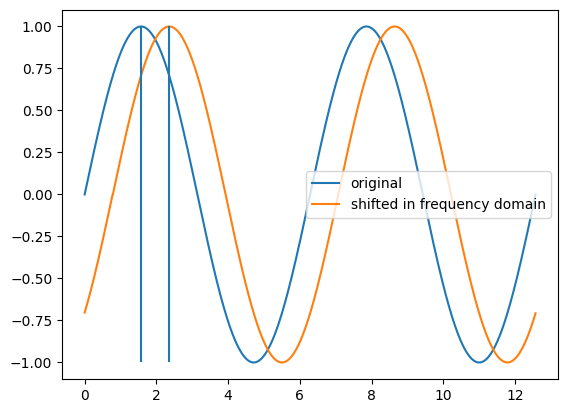

In [135]:
import numpy as np
from matplotlib.pyplot import plot, legend
def shift(signal, shift_by, waves):
    delta = np.zeros(len(signal))
    wave_length = len(signal)/waves
    shift_by *= wave_length/(2*np.pi)
    delta[int(shift_by)] = 1.0
    fft_delta = np.fft.fft(delta)
    fft_signal = np.fft.fft(signal)*fft_delta
    shifted_signal = np.fft.ifft(fft_signal)
    return shifted_signal.real

t = np.linspace(0, 4*np.pi, 2000)
v0 = np.sin(t)
vs = shift(v0, shift_by=np.pi/4, waves=2)  # shift by pi/2
plot(t, v0 , label='original' )
plot(t,vs,label='shifted in frequency domain')
plt.vlines(x=np.pi/2,ymin=-1, ymax=1)
plt.vlines(x=3*np.pi/4,ymin=-1, ymax=1)
legend()

In [116]:
output_neuron = my_resonator.neurons[0]
y_events = output_neuron.out_spikes()
y_events = y_events[(y_events > (duration - (10/signal_freq)) * clk_freq) & (y_events < (duration - (5/signal_freq)) * clk_freq)]
y_events -= y_events[0]
y_spikes = np.zeros(int(5/signal_freq * clk_freq) + 1)
y_spikes[y_events] = 1
y_spikes_rollsum = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
max_spikes = np.max(y_spikes_rollsum)
min_spikes = np.min(y_spikes_rollsum)
normalize_roll0 = (y_spikes_rollsum-min_spikes)/(max_spikes - min_spikes)
normalize_roll0 = normalize_roll0*2-1

output_neuron = my_resonator.neurons[-1]
y_events = output_neuron.out_spikes()
y_events = y_events[(y_events > (duration - (10/signal_freq)) * clk_freq) & (y_events < (duration - (5/signal_freq)) * clk_freq)]
y_events -= y_events[0]
y_spikes = np.zeros(int(5/signal_freq * clk_freq) + 1)
# y_spikes = np.zeros(y_events[-1] + 1)
y_spikes[y_events] = 1
y_spikes_rollsum = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
max_spikes = np.max(y_spikes_rollsum)
min_spikes = np.min(y_spikes_rollsum)
normalize_roll1 = (y_spikes_rollsum-min_spikes)/(max_spikes - min_spikes)
normalize_roll1 = normalize_roll1*2-1
signal_length = min(len(normalize_roll1), len(normalize_roll0))
print(f'mse {np.sum((normalize_roll1[:signal_length] + normalize_roll0[:signal_length]) ** 2)/signal_length}')

mse 0.0001319395965263285


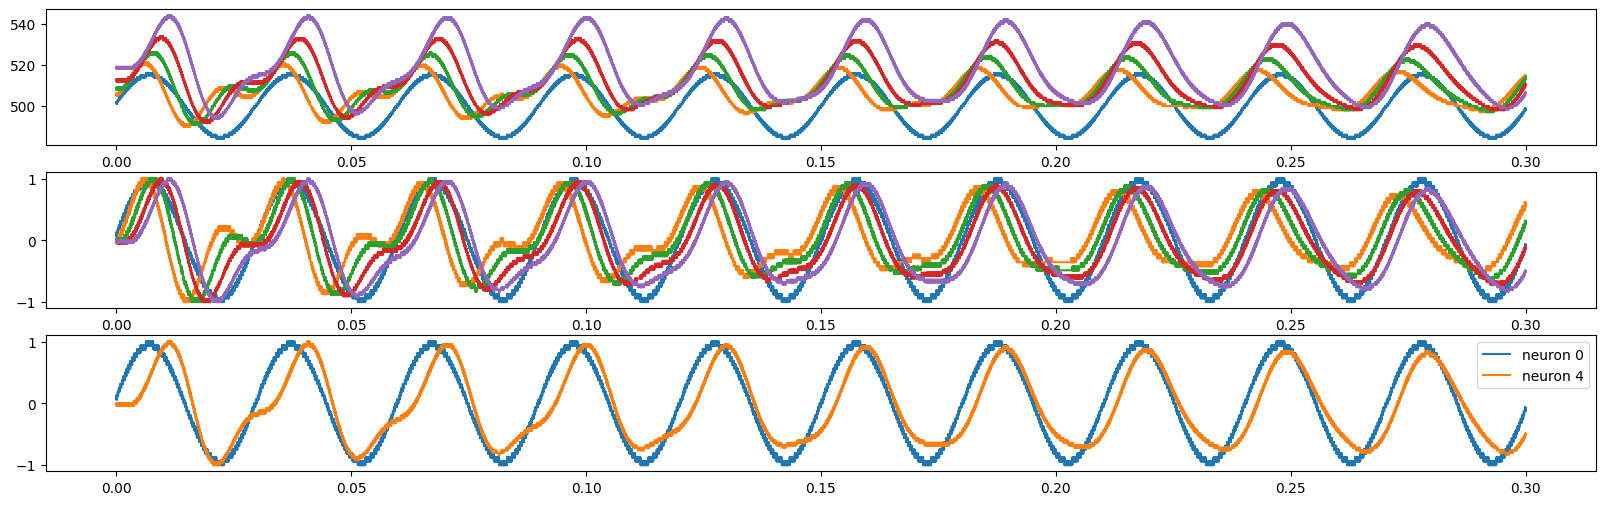

In [59]:
duration = .3

resonator_freq = '104'
clk_freq = 1536000
my_resonator = create_base_resonator(freq0=resonator_freq, clk_freq=clk_freq)

signal_freq = 50

neurons_log_spikes = range(5)
for i in neurons_log_spikes:
    my_resonator.log_out_spikes(i)

spectrum = duration

x = np.linspace(0, spectrum, int(duration * clk_freq))
t = x * 2 * np.pi * signal_freq
sine_wave = np.sin(t)

my_resonator.input_full_data(np.zeros(clk_freq * 1))
for i in neurons_log_spikes:
    output_neuron = my_resonator.neurons[i]
    output_neuron.forget_logs()
my_resonator.input_full_data(sine_wave)

spikes_window_size = 1000

fig, axs = plt.subplots(3, 1, figsize=(20, 6))
for i in neurons_log_spikes:
    output_neuron = my_resonator.neurons[i]
    y_events = output_neuron.out_spikes()
    y_events = y_events[(y_events > (duration - (15/signal_freq)) * clk_freq) & (y_events < (duration - (5/signal_freq)) * clk_freq)]
    y_events -= y_events[0]
    y_spikes = np.zeros(y_events[-1] + 1)
    y_spikes[y_events] = 1
    y_spikes_rollsum = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
    max_spikes = np.max(y_spikes_rollsum)
    min_spikes = np.min(y_spikes_rollsum)
    normalize_roll = (y_spikes_rollsum-min_spikes)/(max_spikes - min_spikes)
    normalize_roll = normalize_roll*2-1

    axs[0].plot(np.linspace(0, duration, len(y_spikes_rollsum)), y_spikes_rollsum, label=f'neuron {i}')
    axs[1].plot(np.linspace(0, duration, len(normalize_roll)), normalize_roll, label=f'neuron {i}')
    if i == 0 or i == 4:
        axs[2].plot(np.linspace(0, duration, len(normalize_roll)), normalize_roll, label=f'neuron {i}')

plt.legend()
plt.show()